# Install Required Packages


In [1]:
!pip install datasets soundfile speechbrain --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.2/807.2 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 15.0 MB/s eta 0:00:00


In [2]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-bjv057vt
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-bjv057vt
  Resolved https://github.com/huggingface/transformers.git to commit 1d063793318b20654ebb850f48f43e0a247ab7bb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 21.2 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.47.0.dev0-py3-none-any.whl size=10036538 sha256=18590150490826fb5f2677bd54689b6a9ec6a9c7923ceb8ee829a4f463be2deb
  Stored in directory: /tmp/pip-ephem-wheel-cache-4l9xezl8/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      S

In [3]:
!pip install --upgrade accelerate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 11.9 MB/s eta 0:00:00


Check GPU

In [4]:
!nvidia-smi

Sat Oct 26 14:32:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

if no GPU found then use GPU of google colab

# Load the model

In [5]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

# Load the dataset

In [13]:
from datasets import load_dataset

dataset = load_dataset("lj_speech", split="train" , trust_remote_code=True)
dataset

Generating train split:   0%|          | 0/13100 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'audio', 'file', 'text', 'normalized_text'],
    num_rows: 13100
})

In [14]:
from datasets import Audio
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [15]:
len(dataset)

13100

# Clean Up Text

The dataset may contain characters that are not in the SpeechT5 tokenizer vocabulary. Those will be converted to <unk> tokens

In [16]:
tokenizer = processor.tokenizer

In [17]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/13100 [00:00<?, ? examples/s]

Now we have two sets of characters, one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. By taking the difference between these sets, we find the characters that are in the dataset but not in the tokenizer.

In [18]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'â', 'è', 'ü', '’', '“', '”'}

In [20]:
replacements = [
    ('à', 'a'),
    ('â', 'a'),
    ('è', 'e'),
    ('ü', 'u'),
    ('’', "'"),
    ('“', '"'),
    ('”', '"'),
    (' ', ' ') # Keep space as is
]

def clean_text(text):
    for char, replacement in replacements:
        text["normalized_text"] = text["normalized_text"].replace(char, replacement)
    return text

dataset = dataset.map(clean_text)

Map:   0%|          | 0/13100 [00:00<?, ? examples/s]

# preparing the dataset

In [24]:
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # # use SpeechBrain to obtain x-vector
    # example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Let's verify the processing is correct by looking at a single example:

In [25]:
processed_example = prepare_dataset(dataset[0])

In [26]:
list(processed_example.keys())

['input_ids', 'labels']

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

In [27]:
tokenizer.decode(processed_example["input_ids"])

'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition</s>'

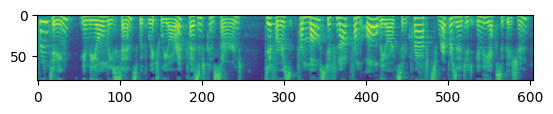

In [28]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

If we run a vocoder on the log-mel spectrogram, it should produce the original audio again. We'll load the HiFi-GAN vocoder from the original SpeechT5 checkpoint.

In [29]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [31]:
import torch
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [32]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

That all looks and sounds good! We can now process the entire dataset. This will take between 5 and 10 minutes.

In [33]:
dataset = dataset.map(
    prepare_dataset, remove_columns=dataset.column_names,
)

Map:   0%|          | 0/13100 [00:00<?, ? examples/s]

Some of the examples in the dataset are apparently longer than the maximum input length the model can handle (600 tokens), so we should remove those from the dataset. In fact, to allow for larger batch sizes we'll remove anything over 200 tokens.

In [34]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])

Filter:   0%|          | 0/13100 [00:00<?, ? examples/s]

In [35]:
len(dataset)

13100

# Train Test Split

In [36]:
dataset = dataset.train_test_split(test_size=0.1)

In [37]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 11790
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1310
    })
})

# Collactor to make batches

We need to define a custom collator to combine multiple examples into a batch. This will pad shorter sequences with padding tokens. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value tells the model to ignore that part of the spectrogram when calculating the spectrogram loss.

In [38]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        # speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        # batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [39]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [40]:
features = [
    dataset["train"][0],
    dataset["train"][1],
    dataset["train"][20],
]

batch = data_collator(features)

In [41]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 145]),
 'attention_mask': torch.Size([3, 145]),
 'labels': torch.Size([3, 592, 80])}

# Training

In [42]:
from huggingface_hub import notebook_login

notebook_login()

The `use_cache=True` option is incompatible with gradient checkpointing. Disable it for training, otherwise it keeps complaining about it.

In [43]:
model.config.use_cache = False

Define the training arguments.

We won't be computing any evaluation metrics during the training process. Instead, we'll only look at the loss. The lower the loss, the better the model.

Note: If you do not want to upload the model checkpoints to the Hub, set `push_to_hub=False`.

In [ ]:
# prompt: load drive

from google.colab import drive
drive.mount('/content/drive')


In [44]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/My Drive/Tts speechT5/speecht5_tts",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Create the trainer object using the model, dataset, and data collator.

In [45]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)

<ipython-input-45-4a9303382841>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
max_steps is given, it will override any value given in num_train_epochs


And with that, we're ready to start training!

Training will take several hours depending on your GPU or the one allocated to the Google Colab. Depending on your GPU, it is possible that you will encounter a CUDA "out-of-memory" error when you start training. In this case, you can reduce the `per_device_train_batch_size` incrementally by factors of 2 and increase `gradient_accumulation_steps` by 2x to compensate.

In [46]:
trainer.train()

Step,Training Loss,Validation Loss
1000,1.596600,0.734715
2000,1.362300,0.611992
3000,1.294400,0.555863
4000,1.293200,0.539118


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2816: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=4000, training_loss=1.560178904056549, metrics={'train_runtime': 6593.3824, 'train_samples_per_second': 19.413, 'train_steps_per_second': 0.607, 'total_flos': 1.7166003390575424e+16, 'train_loss': 1.560178904056549, 'epoch': 10.854816824966079})

If we do one more `push_to_hub()` after training we can get a nice model card built for us. We simply have to set the appropriate keyword arguments (kwargs). You can change these values to match your dataset, language and model name accordingly:

In [54]:
kwargs = {
    "dataset_tags": "lj_speech",
    "dataset": "LJSpeech",  # a 'pretty' name for the training dataset
    "dataset_args": "split: train",
    "language": "en",
    "model_name": "SpeechT5 TTS English (LJSpeech)",  # a 'pretty' name for your model
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech"
    # "tags": ["speech", "text-to-speech", "tts", "audio"],
}

The training results can now be uploaded to the Hub. To do so, execute the `push_to_hub` command:

In [55]:
trainer.push_to_hub(**kwargs)

CommitInfo(commit_url='https://huggingface.co/tawheed-tariq/speecht5_tts/commit/1c832de03aeca79cebf3c0242260159cee863a44', commit_message='End of training', commit_description='', oid='1c832de03aeca79cebf3c0242260159cee863a44', pr_url=None, pr_revision=None, pr_num=None)

You can now share this model with anyone using the link on the Hub.

# Evaluate

loading model from hugging face

In [56]:
model = SpeechT5ForTextToSpeech.from_pretrained("tawheed-tariq/speecht5_tts")

config.json:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [57]:
example = dataset["test"][304]

In [168]:
text = "hello i am tawheed helping muskaan to smile"

In [169]:
tokenizer.decode(tokenizer(text)["input_ids"])

'hello i am tawheed helping muskaan to smile</s>'

In [170]:
inputs = processor(text=text, return_tensors="pt")

In [171]:
from datasets import load_dataset
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")

speaker_embeddings = embeddings_dataset[7306]["xvector"]
speaker_embeddings = torch.tensor(speaker_embeddings).unsqueeze(0)


In [172]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

In [173]:
# Generate audio directly - no reshaping needed
with torch.no_grad():
    speech = vocoder(spectrogram)

In [174]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)

In [167]:
import soundfile as sf
sf.write("output.wav", speech.numpy(), samplerate=16000)